IMPORTING MODULES

In [1]:
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime
from IPython.display import Audio,display
import librosa
import librosa.display as lplt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import dct
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,AveragePooling1D,Flatten,Dense,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tkinter import *
from tkinter import filedialog
from pygame import mixer

pygame 2.5.2 (SDL 2.28.3, Python 3.8.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


SETTING UP DATASET PATH

In [2]:
audio_data_path="D:/Srinath/sem6/ML/Mini Project/Dataset/Dataset"
metadata=pd.read_csv("D:/Srinath/sem6/ML/Mini Project/Dataset/Dataset/features_30_sec.csv")
df = pd.read_csv("D:/Srinath/sem6/ML/Mini Project/Dataset/Dataset/dataset_list.csv")

In [3]:
audio_data, sr = librosa.load("D:/Srinath/sem6/ML/Mini Project/Dataset/Dataset/blues/blues.00003.wav")

EDA

C:\Users\Srinath\AppData\Local\Temp\ipykernel_15664\728871748.py:4: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  stft_db = librosa.amplitude_to_db(stft, ref=np.max)
C:\Users\Srinath\AppData\Local\Temp\ipykernel_15664\728871748.py:6: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


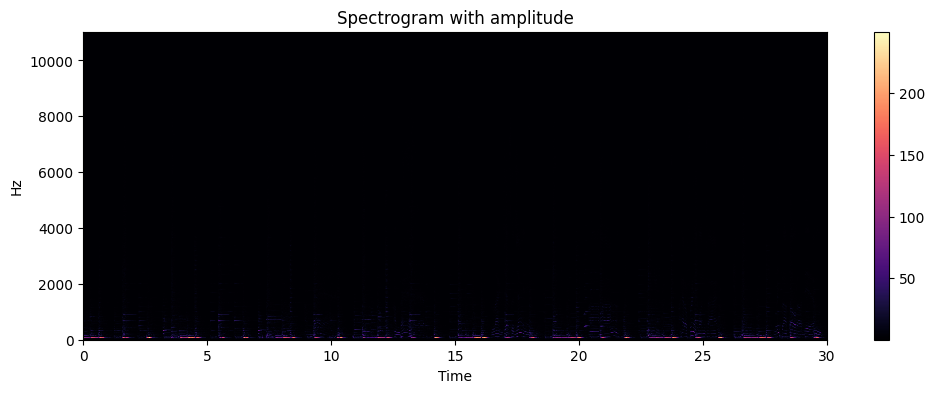

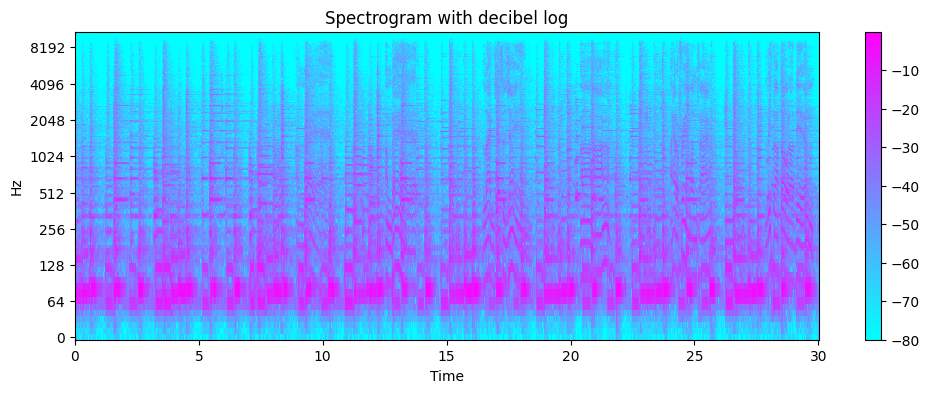

In [4]:
n_fft=2048 
hop_length=512
stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)
plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()
plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

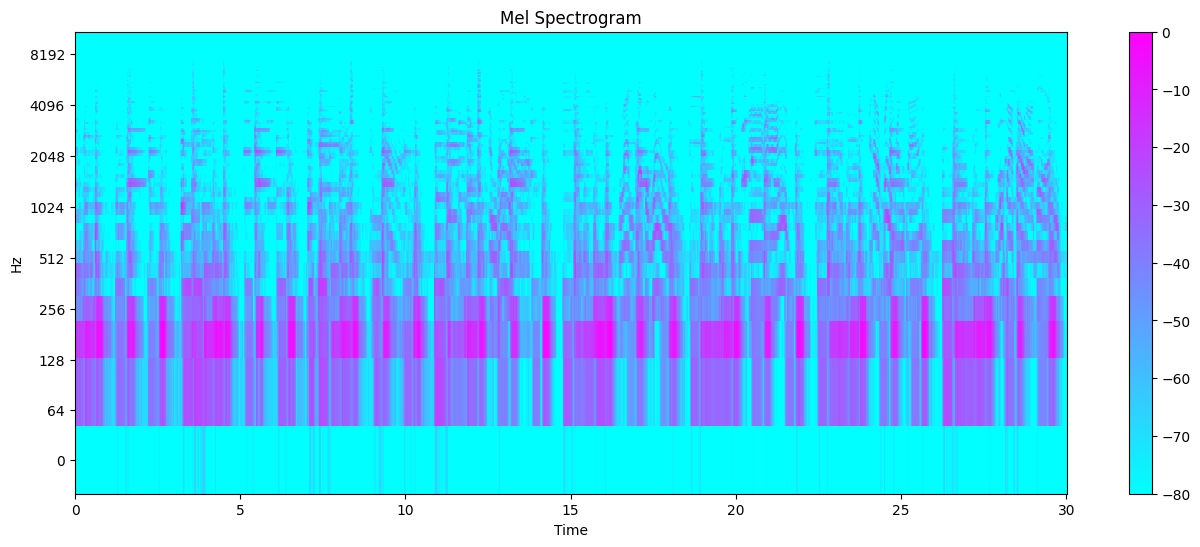

In [5]:
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

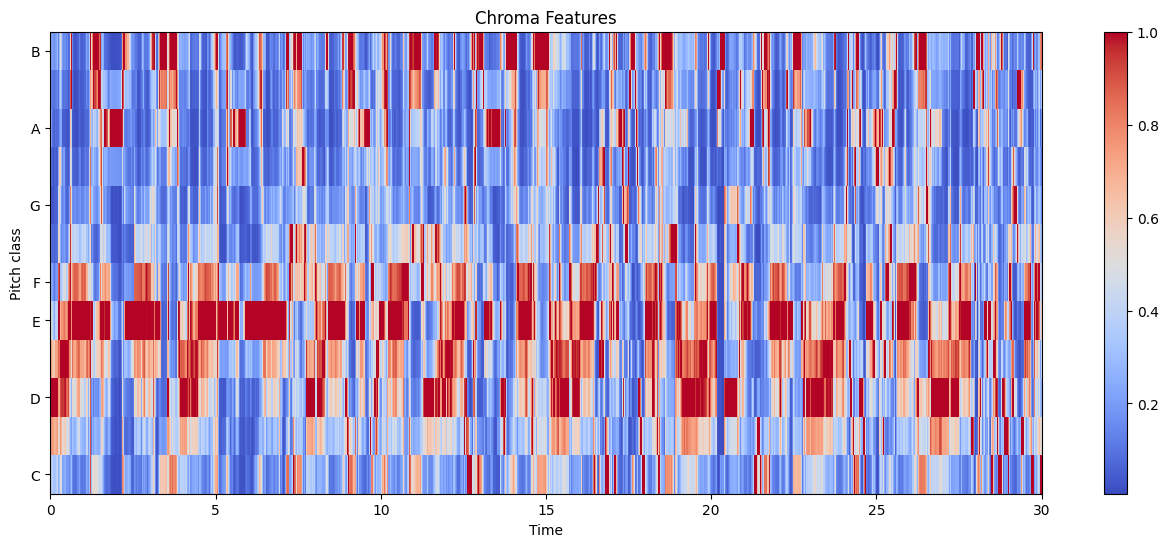

In [6]:
chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

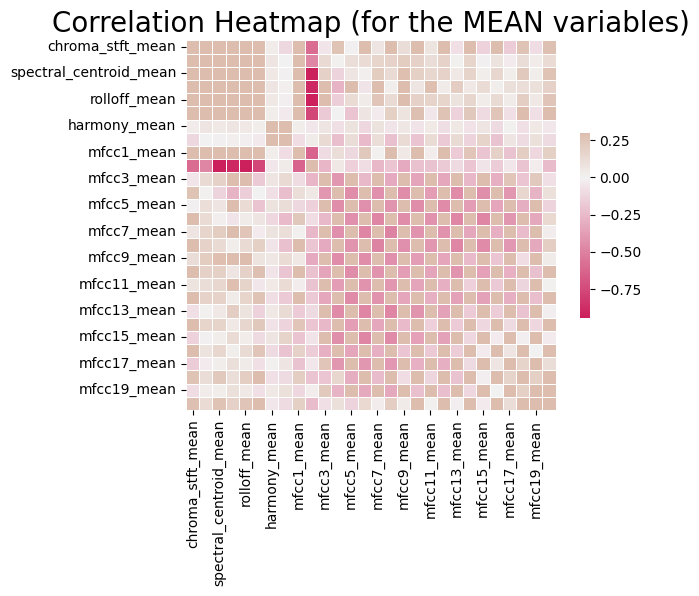

In [7]:
spike_cols = [col for col in metadata.columns if 'mean' in col]
corr = metadata[spike_cols].corr()
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

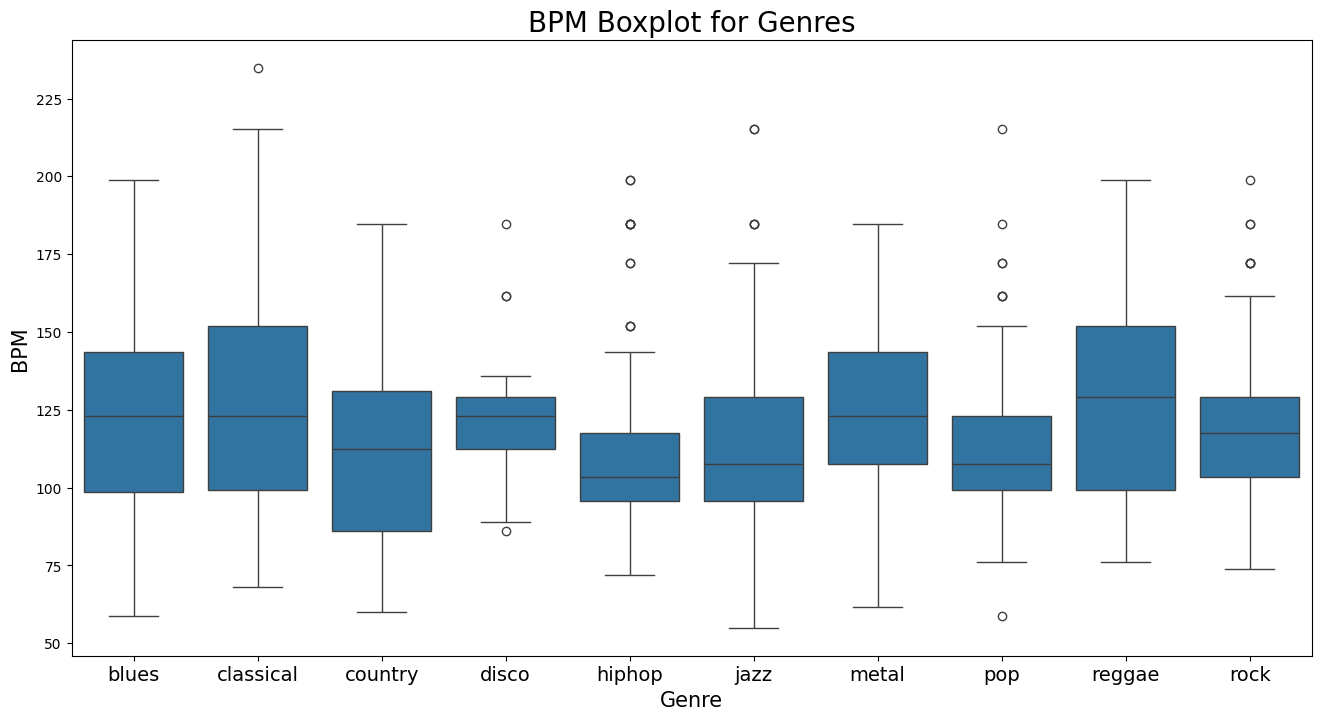

In [8]:
x = metadata[["label", "tempo"]]
fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x);
plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.show()

FEATURE EXTRACTION ALGORITHMS

In [9]:
def mfcc_feature_extractor(file):
    audio, sr = librosa.load(file)
    mfcc_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40, n_mels=40)
    mfcc_scaled_features = np.mean(mfcc_features.T, axis=0)
    return mfcc_scaled_features

In [10]:
def stft_feature_extractor(audio_file, n_fft=2048, hop_length=512, n_features=40):
    y, sr = librosa.load(audio_file)    
    stft = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    stft_mean = np.mean(stft, axis=1)
    if stft_mean.shape[0] > n_features:
        stft_mean = stft_mean[:n_features]
    elif stft_mean.shape[0] < n_features:
        pad_width = (0, n_features - stft_mean.shape[0])
        stft_mean = np.pad(stft_mean, pad_width, mode='constant', constant_values=0)
    return tuple(stft_mean)

EXTRACTING MFCC FEATURES

In [13]:
extracted_features_mfcc = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Audio Files (MFCC)"):
    try:
        final_class_label = row['LABEL']
        file_name = os.path.join(os.path.abspath(audio_data_path), final_class_label, str(row['FILENAME']))
        data = mfcc_feature_extractor(file_name)
        extracted_features_mfcc.append([data, final_class_label])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

Processing Audio Files (MFCC):  23%|███████████                                     | 632/2741 [02:40<01:47, 19.68it/s]

Error processing D:\Srinath\sem6\ML\Mini Project\Dataset\Dataset\jazz\jazz.00054.wav: module 'soundfile' has no attribute 'SoundFileRuntimeError'


Processing Audio Files (MFCC):  78%|████████████████████████████████████▊          | 2147/2741 [11:17<00:24, 23.92it/s]C:\Users\Srinath\AppData\Roaming\Python\Python38\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1424
  warnings.warn(
Processing Audio Files (MFCC):  78%|████████████████████████████████████▉          | 2151/2741 [11:17<00:21, 27.25it/s]C:\Users\Srinath\AppData\Roaming\Python\Python38\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=577
  warnings.warn(
Processing Audio Files (MFCC):  92%|███████████████████████████████████████████▎   | 2529/2741 [19:09<01:36,  2.20it/s]


KeyboardInterrupt: 

EXTRACTING STFT FEATURES

In [ ]:
extracted_features_stft = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Audio Files (STFT)"):
    try:
        final_class_label = row['LABEL']
        file_name = os.path.join(os.path.abspath(audio_data_path), final_class_label, str(row['FILENAME']))
        data = stft_feature_extractor(file_name)
        extracted_features_stft.append([data, final_class_label])
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

SPLITTING TRAINING TESTING DATA

In [ ]:
x_mfcc = np.array([item[0] for item in extracted_features_mfcc])
y_mfcc = np.array([item[1] for item in extracted_features_mfcc])

x_stft = np.array([item[0] for item in extracted_features_stft])
y_stft = np.array([item[1] for item in extracted_features_stft])

In [35]:
le = LabelEncoder()
#y_mfcc = to_categorical(le.fit_transform(y_mfcc))
#y_stft = to_categorical(le.fit_transform(y_stft))

In [ ]:
x_train_mfcc, x_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(x_mfcc, y_mfcc, test_size=0.2, random_state=42)
x_train_stft, x_test_stft, y_train_stft, y_test_stft = train_test_split(x_stft, y_stft, test_size=0.2, random_state=42)

CNN MODEL FOR MFCC

In [14]:
mfcc_model = Sequential()
mfcc_model.add(Input(shape=(40,1)))
mfcc_model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
mfcc_model.add(MaxPooling1D(pool_size=1))
mfcc_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
mfcc_model.add(MaxPooling1D(pool_size=1))
mfcc_model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
mfcc_model.add(MaxPooling1D(pool_size=1))
mfcc_model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
mfcc_model.add(MaxPooling1D(pool_size=1))
mfcc_model.add(Conv1D(filters=1024, kernel_size=2, activation='relu'))
mfcc_model.add(AveragePooling1D(pool_size=1))
mfcc_model.add(Flatten())
mfcc_model.add(Dense(200, activation='relu'))
mfcc_model.add(Dense(14, activation='softmax'))

In [15]:
checkpoint_path = "best_mfcc_model_weights.hd5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
mfcc_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [17]:
mfcc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 39, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 128)           16512     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 256)           65792     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 37, 256)           0

In [48]:
print(x_train_mfcc.shape)
print(y_train_mfcc.shape)
print(x_test_mfcc.shape)
print(y_test_mfcc.shape)

(2192, 40)
(2192, 14)
(548, 40)
(548, 14)


In [50]:
history_mfcc = mfcc_model.fit(x_train_mfcc, y_train_mfcc, batch_size=32, epochs=10,validation_data=(x_test_mfcc, y_test_mfcc), callbacks=[checkpoint])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9804
Epoch 1: val_accuracy did not improve from 0.77555
69/69 [==============================] - 93s 1s/step - loss: 0.0666 - accuracy: 0.9804 - val_loss: 1.5229 - val_accuracy: 0.7628
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9872
Epoch 2: val_accuracy did not improve from 0.77555
69/69 [==============================] - 28s 403ms/step - loss: 0.0404 - accuracy: 0.9872 - val_loss: 1.5473 - val_accuracy: 0.7701
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9863
Epoch 3: val_accuracy did not improve from 0.77555
69/69 [==============================] - 28s 411ms/step - loss: 0.0483 - accuracy: 0.9863 - val_loss: 1.6386 - val_accuracy: 0.7682
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9854
Epoch 4: val_accuracy did not improve from 0.77555
69/69 [====================

INFO:tensorflow:Assets written to: best_mfcc_model_weights.hd5\assets


69/69 [==============================] - 115s 2s/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 1.5099 - val_accuracy: 0.7938
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9964
Epoch 7: val_accuracy did not improve from 0.79380
69/69 [==============================] - 96s 1s/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 1.6551 - val_accuracy: 0.7719
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9964
Epoch 8: val_accuracy did not improve from 0.79380
69/69 [==============================] - 56s 805ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 1.6553 - val_accuracy: 0.7883
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9995
Epoch 9: val_accuracy did not improve from 0.79380
69/69 [==============================] - 28s 407ms/step - loss: 0.0045 - accuracy: 0.9995 - val_loss: 1.7559 - val_accuracy: 0.7847
Epoch 10/10
69/69 [=======================

INFO:tensorflow:Assets written to: best_mfcc_model_weights.hd5\assets


69/69 [==============================] - 32s 471ms/step - loss: 6.8657e-04 - accuracy: 1.0000 - val_loss: 1.8437 - val_accuracy: 0.7956


CNN MODEL FOR STFT

In [18]:
input_stft = Input(shape=(40, 1))
conv1 = Conv1D(64, kernel_size=2, activation='relu')(input_stft)
maxpool1 = MaxPooling1D(pool_size=1)(conv1)
conv2 = Conv1D(128, kernel_size=2, activation='relu')(maxpool1)
maxpool2 = MaxPooling1D(pool_size=1)(conv2)
conv3 = Conv1D(256, kernel_size=2, activation='relu')(maxpool2)
maxpool3 = MaxPooling1D(pool_size=1)(conv3)
conv4 = Conv1D(512, kernel_size=2, activation='relu')(maxpool3)
maxpool4 = MaxPooling1D(pool_size=1)(conv4)
conv5 = Conv1D(1024, kernel_size=2, activation='relu')(maxpool4)
maxpool5 = AveragePooling1D(pool_size=1)(conv5)
flatten = Flatten()(maxpool5)
dense1 = Dense(200, activation='relu')(flatten)
dense2 = Dense(14, activation='softmax')(dense1)
stft_model = Model(inputs=input_stft, outputs=dense2)

In [19]:
stft_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
checkpoint_stft_path = "best_stft_model_weights.hd5"
checkpoint_stft = ModelCheckpoint(checkpoint_stft_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [21]:
stft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 39, 64)            192       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 39, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 38, 128)           16512     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 38, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 37, 256)           65792 

In [56]:
history_stft = stft_model.fit(x_train_stft, y_train_stft, batch_size=32, epochs=10,validation_data=(x_test_stft, y_test_stft), callbacks=[checkpoint_stft])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.9551 - accuracy: 0.4165
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 39s 464ms/step - loss: 1.9551 - accuracy: 0.4165 - val_loss: 1.4230 - val_accuracy: 0.5000
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.5876
Epoch 2: val_accuracy improved from 0.50000 to 0.58394, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 104s 2s/step - loss: 1.2254 - accuracy: 0.5876 - val_loss: 1.2641 - val_accuracy: 0.5839
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.6533
Epoch 3: val_accuracy improved from 0.58394 to 0.59672, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 106s 2s/step - loss: 1.0472 - accuracy: 0.6533 - val_loss: 1.1980 - val_accuracy: 0.5967
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.9087 - accuracy: 0.6953
Epoch 4: val_accuracy improved from 0.59672 to 0.65693, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 94s 1s/step - loss: 0.9087 - accuracy: 0.6953 - val_loss: 1.0670 - val_accuracy: 0.6569
Epoch 5/10
69/69 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.7564
Epoch 5: val_accuracy did not improve from 0.65693
69/69 [==============================] - 28s 401ms/step - loss: 0.7451 - accuracy: 0.7564 - val_loss: 1.0956 - val_accuracy: 0.6332
Epoch 6/10
69/69 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.8043
Epoch 6: val_accuracy did not improve from 0.65693
69/69 [==============================] - 28s 408ms/step - loss: 0.6031 - accuracy: 0.8043 - val_loss: 1.4236 - val_accuracy: 0.6369
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8216
Epoch 7: val_accuracy improved from 0.65693 to 0.67153, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 31s 455ms/step - loss: 0.5239 - accuracy: 0.8216 - val_loss: 1.1395 - val_accuracy: 0.6715
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8759
Epoch 8: val_accuracy did not improve from 0.67153
69/69 [==============================] - 67s 973ms/step - loss: 0.3655 - accuracy: 0.8759 - val_loss: 1.5119 - val_accuracy: 0.6624
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.3059 - accuracy: 0.9001
Epoch 9: val_accuracy did not improve from 0.67153
69/69 [==============================] - 95s 1s/step - loss: 0.3059 - accuracy: 0.9001 - val_loss: 1.4627 - val_accuracy: 0.6551
Epoch 10/10
69/69 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9183
Epoch 10: val_accuracy improved from 0.67153 to 0.68248, saving model to best_stft_model_weights.hd5
INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_stft_model_weights.hd5\assets


69/69 [==============================] - 106s 2s/step - loss: 0.2455 - accuracy: 0.9183 - val_loss: 1.5023 - val_accuracy: 0.6825


CONCATENATED MODEL WITHOUT OPTIMIZATION

In [57]:
mfcc_output = mfcc_model.layers[-2].output
stft_output = stft_model.layers[-2].output
input1 = mfcc_model.layers[0].input
input2 = stft_model.input

In [58]:
concatenated = Concatenate()([mfcc_output, stft_output])
output = Dense(14, activation='softmax')(concatenated)
combined_model = Model(inputs=[input1, input2], outputs=output)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
checkpoint_combined_path = "best_combined_model_weights.hd5"
checkpoint_combined = ModelCheckpoint(checkpoint_combined_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [60]:
history_combined = combined_model.fit([x_train_mfcc, x_train_stft], y_train_mfcc, batch_size=32, epochs=10,validation_data=([x_test_mfcc, x_test_stft], y_test_mfcc),callbacks=[checkpoint_combined])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.5042 - accuracy: 0.6355
Epoch 1: val_accuracy improved from -inf to 0.75730, saving model to best_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


69/69 [==============================] - 82s 933ms/step - loss: 1.5042 - accuracy: 0.6355 - val_loss: 0.7737 - val_accuracy: 0.7573
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8659
Epoch 2: val_accuracy improved from 0.75730 to 0.78650, saving model to best_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


69/69 [==============================] - 56s 811ms/step - loss: 0.4187 - accuracy: 0.8659 - val_loss: 0.7594 - val_accuracy: 0.7865
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9580
Epoch 3: val_accuracy improved from 0.78650 to 0.79927, saving model to best_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


69/69 [==============================] - 163s 2s/step - loss: 0.1274 - accuracy: 0.9580 - val_loss: 0.8188 - val_accuracy: 0.7993
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9872
Epoch 4: val_accuracy did not improve from 0.79927
69/69 [==============================] - 134s 2s/step - loss: 0.0450 - accuracy: 0.9872 - val_loss: 0.9463 - val_accuracy: 0.7956
Epoch 5/10
69/69 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9913
Epoch 5: val_accuracy improved from 0.79927 to 0.81204, saving model to best_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


69/69 [==============================] - 66s 961ms/step - loss: 0.0232 - accuracy: 0.9913 - val_loss: 0.9988 - val_accuracy: 0.8120
Epoch 6/10
69/69 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9968
Epoch 6: val_accuracy improved from 0.81204 to 0.82847, saving model to best_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_combined_model_weights.hd5\assets


69/69 [==============================] - 91s 1s/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.9830 - val_accuracy: 0.8285
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9891
Epoch 7: val_accuracy did not improve from 0.82847
69/69 [==============================] - 161s 2s/step - loss: 0.0392 - accuracy: 0.9891 - val_loss: 1.1662 - val_accuracy: 0.7737
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9790
Epoch 8: val_accuracy did not improve from 0.82847
69/69 [==============================] - 162s 2s/step - loss: 0.0635 - accuracy: 0.9790 - val_loss: 1.0816 - val_accuracy: 0.7865
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9790
Epoch 9: val_accuracy did not improve from 0.82847
69/69 [==============================] - 59s 825ms/step - loss: 0.0644 - accuracy: 0.9790 - val_loss: 0.9578 - val_accuracy: 0.8175
Epoch 10/10
69/69 [=========================

In [61]:
combined_model.load_weights(checkpoint_combined_path)
loss, acc = combined_model.evaluate([x_test_mfcc, x_test_stft], y_test_mfcc)
print("Accuracy (Best Combined Model):", acc)

18/18 [==============================] - 8s 453ms/step - loss: 0.9830 - accuracy: 0.8285
Accuracy (Best Combined Model): 0.8284671306610107


BLACK HOLE OPTIMIZATION

In [62]:
num_stars = 20 
num_iterations = 50 
threshold = 1e-4
n_features = 40 
n_classes = 14 

In [69]:
def evaluate_fitness(solution):
    predictions = np.mean(mfcc_model.predict(solution.reshape(1, n_features, 1))[0])    
    return predictions
    
def evaluate_fitness_stft(solution):
    predictions = np.mean(stft_model.predict(solution.reshape(1, n_features, 1))[0])
    return predictions

In [70]:
population = np.random.rand(num_stars, n_features) 
fitness_values = np.zeros(num_stars)
population_stft = np.random.rand(num_stars, n_features)
fitness_values_stft = np.zeros(num_stars)

In [71]:
for i in range(num_stars):
    fitness_values[i] = evaluate_fitness(population[i])


for i in range(num_stars):
    fitness_values_stft[i] = evaluate_fitness(population_stft[i])

print("Fitness values for MFCC:",fitness_values)
print("Fitness values for STFT:",fitness_values_stft)

1/1 [==============================] - 0s 26ms/step
Fitness values for MFCC: [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142856 0.07142857 0.07142856 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142858 0.07142857]
Fitness values for STFT: [0.07142857 0.07142857 0.07142857 0.07142858 0.07142857 0.07142858
 0.07142857 0.07142857 0.07142857 0.07142858 0.07142856 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142858]


In [72]:
best_index = np.argmin(fitness_values)
black_hole = population[best_index]
best_fitness = fitness_values[best_index]

best_index_stft = np.argmin(fitness_values_stft)
black_hole_stft = population_stft[best_index_stft]
best_fitness_stft = fitness_values_stft[best_index_stft]

In [73]:
for iteration in range(num_iterations):
    for i in range(num_stars):
        if np.array_equal(population[i], black_hole):
            continue  
        population[i] = np.random.rand(n_features)
    R = 0.5 * np.max(np.abs(black_hole - population), axis=0)  
    for i in range(num_stars):
        fitness = evaluate_fitness(population[i])
        if fitness < best_fitness:
            black_hole = population[i]
            best_fitness = fitness
        distance_to_black_hole = np.linalg.norm(population[i] - black_hole)
        if np.all(distance_to_black_hole < R):
            population[i] = np.random.rand(n_features)
    if best_fitness < threshold:
        print("Termination condition met. Best fitness:", best_fitness)
        break
    print("Iteration:", iteration + 1, "Best fitness:", best_fitness)

1/1 [==============================] - 0s 23ms/step
Iteration: 1 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 25ms/step
Iteration: 2 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 31ms/step
Iteration: 3 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 28ms/step
Iteration: 4 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 19ms/step
Iteration: 5 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 25ms/step
Iteration: 6 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 22ms/step
Iteration: 7 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 29ms/step
Iteration: 8 Best fitness: 0.0714285597205162
1/1 [==============================] - 0s 31ms/step
Iteration: 9 Best fitness: 0.07142855
1/1 [==============================] - 0s 24ms/step
Iteration: 10 Best fitness: 0.07142855
1/1 [==============================

In [74]:
for iteration in range(num_iterations):
    for i in range(num_stars):
        if np.array_equal(population_stft[i], black_hole_stft):
            continue 
        population_stft[i] = np.random.rand(n_features)
    R = 0.5 * np.max(np.abs(black_hole_stft - population_stft), axis=0)
    for i in range(num_stars):
        fitness_stft = evaluate_fitness_stft(population_stft[i])
        if fitness_stft < best_fitness_stft:
            black_hole_stft = population_stft[i]
            best_fitness_stft = fitness_stft
        distance_to_black_hole = np.linalg.norm(population_stft[i] - black_hole_stft)
        if np.all(distance_to_black_hole < R):
            population_stft[i] = np.random.rand(n_features)
    if best_fitness_stft < threshold:
        print("Termination condition met. Best fitness:", best_fitness)
        break
    print("Iteration:", iteration + 1, "Best fitness:", best_fitness)

1/1 [==============================] - 0s 19ms/step
Iteration: 1 Best fitness: 0.07142855
1/1 [==============================] - 0s 26ms/step
Iteration: 2 Best fitness: 0.07142855
1/1 [==============================] - 0s 30ms/step
Iteration: 3 Best fitness: 0.07142855
1/1 [==============================] - 0s 19ms/step
Iteration: 4 Best fitness: 0.07142855
1/1 [==============================] - 0s 32ms/step
Iteration: 5 Best fitness: 0.07142855
1/1 [==============================] - 0s 28ms/step
Iteration: 6 Best fitness: 0.07142855
1/1 [==============================] - 0s 25ms/step
Iteration: 7 Best fitness: 0.07142855
1/1 [==============================] - 0s 32ms/step
Iteration: 8 Best fitness: 0.07142855
1/1 [==============================] - 0s 17ms/step
Iteration: 9 Best fitness: 0.07142855
1/1 [==============================] - 0s 17ms/step
Iteration: 10 Best fitness: 0.07142855
1/1 [==============================] - 0s 21ms/step
Iteration: 11 Best fitness: 0.07142855
1/1 [===

CONCATENATED MODEL AFTER OPTIMIZATIION

In [22]:
concatenated_model = Concatenate()([mfcc_model.layers[-2].output, stft_model.layers[-2].output])
output_layer = Dense(14, activation='softmax')(concatenated_model)

In [23]:
optimized_combined_model = Model(inputs=[mfcc_model.layers[0].input, stft_model.input], outputs=output_layer)

In [24]:
optimized_combined_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
checkpoint_optimized_combined_path = "best_optimized_combined_model_weights.hd5"
checkpoint_optimized_combined = ModelCheckpoint(checkpoint_optimized_combined_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [79]:
history_optimized_combined = optimized_combined_model.fit([x_train_mfcc, x_train_stft], y_train_mfcc, batch_size=32, epochs=10,validation_data=([x_test_mfcc, x_test_stft], y_test_mfcc),callbacks=[checkpoint_optimized_combined])

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 1.4136 - accuracy: 0.6775
Epoch 1: val_accuracy improved from -inf to 0.77920, saving model to best_optimized_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_optimized_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_optimized_combined_model_weights.hd5\assets


69/69 [==============================] - 138s 2s/step - loss: 1.4136 - accuracy: 0.6775 - val_loss: 0.7284 - val_accuracy: 0.7792
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9275
Epoch 2: val_accuracy improved from 0.77920 to 0.81934, saving model to best_optimized_combined_model_weights.hd5
INFO:tensorflow:Assets written to: best_optimized_combined_model_weights.hd5\assets


INFO:tensorflow:Assets written to: best_optimized_combined_model_weights.hd5\assets


69/69 [==============================] - 56s 814ms/step - loss: 0.2236 - accuracy: 0.9275 - val_loss: 0.6716 - val_accuracy: 0.8193
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9900
Epoch 3: val_accuracy did not improve from 0.81934
69/69 [==============================] - 131s 2s/step - loss: 0.0389 - accuracy: 0.9900 - val_loss: 1.0357 - val_accuracy: 0.8084
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9904
Epoch 4: val_accuracy did not improve from 0.81934
69/69 [==============================] - 164s 2s/step - loss: 0.0416 - accuracy: 0.9904 - val_loss: 0.9792 - val_accuracy: 0.8175
Epoch 5/10
69/69 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9964
Epoch 5: val_accuracy did not improve from 0.81934
69/69 [==============================] - 161s 2s/step - loss: 0.0104 - accuracy: 0.9964 - val_loss: 1.0607 - val_accuracy: 0.8084
Epoch 6/10
69/69 [=========================

INFO:tensorflow:Assets written to: best_optimized_combined_model_weights.hd5\assets


69/69 [==============================] - 186s 3s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.0390 - val_accuracy: 0.8285
Epoch 7/10
69/69 [==============================] - ETA: 0s - loss: 3.8245e-04 - accuracy: 1.0000
Epoch 7: val_accuracy did not improve from 0.82847
69/69 [==============================] - 163s 2s/step - loss: 3.8245e-04 - accuracy: 1.0000 - val_loss: 1.0585 - val_accuracy: 0.8248
Epoch 8/10
69/69 [==============================] - ETA: 0s - loss: 2.0101e-04 - accuracy: 1.0000
Epoch 8: val_accuracy did not improve from 0.82847
69/69 [==============================] - 157s 2s/step - loss: 2.0101e-04 - accuracy: 1.0000 - val_loss: 1.0923 - val_accuracy: 0.8248
Epoch 9/10
69/69 [==============================] - ETA: 0s - loss: 1.1978e-04 - accuracy: 1.0000
Epoch 9: val_accuracy did not improve from 0.82847
69/69 [==============================] - 163s 2s/step - loss: 1.1978e-04 - accuracy: 1.0000 - val_loss: 1.1258 - val_accuracy: 0.8285
Epoch 10/10
69/69 [==

In [28]:
optimized_combined_model.load_weights(checkpoint_optimized_combined_path)
#optimized_loss,optimized_acc = optimized_combined_model.evaluate([x_test_mfcc, x_test_stft], y_test_mfcc)
#print("Accuracy (Best Optimized Combined Model):",optimized_acc)

In [81]:
combined_model_predictions = combined_model.predict([x_test_mfcc, x_test_stft]) 

18/18 [==============================] - 2s 97ms/step


In [82]:
predicted_labels = np.argmax(combined_model_predictions, axis=1)

In [83]:
true_labels = np.argmax(y_test_mfcc, axis=1) 

In [84]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.83      0.83      0.83        42
           2       0.55      0.33      0.41        18
           3       0.69      0.41      0.51        27
           4       0.77      0.65      0.71        26
           5       0.77      1.00      0.87        41
           6       0.77      0.83      0.80        12
           7       0.70      1.00      0.82        16
           8       0.96      0.95      0.95       184
           9       0.73      0.70      0.71        23
          10       0.50      0.63      0.56        19
          11       0.43      0.39      0.41        23
          12       0.98      0.96      0.97        83
          13       0.71      0.67      0.69        18

    accuracy                           0.83       548
   macro avg       0.72      0.74      0.72       548
weighted avg       0.83      0.83      0.82       548



In [85]:
cm = confusion_matrix(true_labels, predicted_labels)

<Axes: >

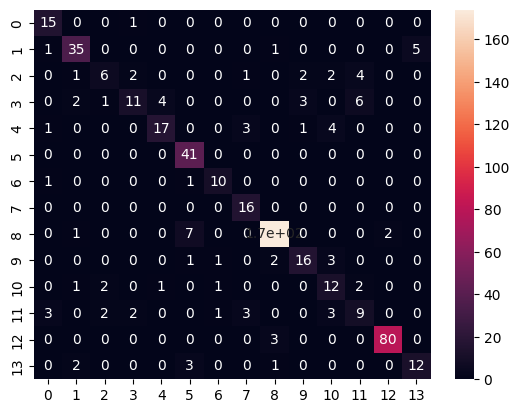

In [86]:
sns.heatmap(cm,annot=True)

In [29]:
def browse_audio():
    global l1,l2,filename
    filename=filedialog.askopenfilename(initialdir="/", title="Select a File", filetypes=(("Wave Audio Format", "*.wav*"),))
    l1=Label(main,text='Check your audio file!',font=("Times New Roman",14),fg='blue')
    l1.place(x=150, y=50)
    l2=Label(text=filename,font=("Times New Roman",12),relief='sunken',width=50,height=4)
    l2.place(x=20,y=100)

In [30]:
def clear():
    l1.destroy()
    l2.destroy()
    l3.destroy()

In [39]:
def predict():
    global l3
    ip1=mfcc_feature_extractor(filename)
    ip2=np.array(stft_feature_extractor(filename))
    inp1=ip1.reshape(1,-1)
    inp2=ip2.reshape(1,-1)
    predictions=optimized_combined_model.predict([inp1,inp2]) 
    ans=predictions.argmax(axis=1)
    #labels=le.classes_
    labels=['blues','classical','country','disco','hiphop','jamendo','jazz','metal','noise','pop','reggae','rock','speech','western']
    txt="Genre: "+labels[ans[0]]
    l3=Label(main,text=txt,font=("Times New Roman",14),fg='blue')
    l3.place(x=200,y=200)

In [42]:
global l1,l2
main=Tk()
main.title('Jolly Raamga')
main.geometry("500x500+400+100")
Label(main,text='Welcome to Audio Classification App',font=("Times New Roman",14),fg='blue').place(x=110, y=20)
Button(main, text='Browse Audio',command=browse_audio).place(x=200, y=250)
Button(main, text='Predict Genre',command=predict).place(x=200, y=300)
Button(main,text='Clear Files',width=10,command=clear).place(x=200,y=350)
Button(main,text='Exit',width=10,command=main.destroy).place(x=200,y=400)
main.mainloop()

1/1 [==============================] - 0s 35ms/step
